# Домашнее задание  
## по теме «Линейная регрессия» 

### Импорт библиотек

In [936]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from eda_tools import return_outliers, return_boxplot, return_eda, detect_outliers_iqr

In [937]:
df = pd.read_csv('input_data/train.csv') # загрузка DataFrame 

### Подготовка исходных данных

In [938]:
df.info(memory_usage=True) # Вывод столбцов и их типов

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


Выводы. Часть столбцов треуют новых, красивых названий. Часть столбцов требуют измения типа данных на int

In [939]:
# Смена названий столбцов
df.rename(columns={
    'store_sales(in millions)': 'cash_sales',
    'unit_sales(in millions)': 'unit_sales',
    'avg_cars_at home(approx).1': 'avg_cars_home'
}, inplace=True)

### Описание столбцов:
- id	- идентификатор записи
- cash_sales - продажи в мл.долларов_евро_сша 
- unit_sales - продажи в штуках
- total_children - общее кол-во детей
- num_children_at_home - кол-во детей в комнате
- avg_cars_home - среднее кол-во автомобилей в доме
- gross_weight - Вес брутто
- recyclable_package - перерабатываемая упаковка
- low_fat - обезжиренный продукт
- units_per_case - кол-во в упаковке
- store_sqft - площадь магазина
- coffee_bar - наличие ковейни
- video_store	- наличие видеомагазина
- salad_bar - наличие малт-бара
- prepared_food - готовая еда
- florist	 - наличие флориста
- cost - стоимость рекламной кампании (ЦЕЛЕВАЯ ПЕРЕМЕННАЯ)


In [940]:
'''
Замена типов данных. Решил заменить float на int для всех полей где нет дробных частей
'''
eda_df = return_eda(df) 

# Проходим по строкам eda_df, где "Дробные" равно 0
for parameter in eda_df[eda_df['Дробные'] == 0].index:
    # Меняем тип данных в исходном DataFrame df
    df[parameter] = df[parameter].astype(int)
# Обновляем eda_df    
eda_df = return_eda(df)
eda_df

,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,
cash_sales,0.0,22.92,0.51,6.337376,5.78,1.094273e+01,2.32,11.04,3.72,8.40,356907,float64,1044,0,0,3442
unit_sales,0.0,6.00,1.00,3.043881,3.00,6.157163e-01,2.00,4.00,3.00,4.00,0,int64,6,0,6765,31
total_children,0.0,5.00,0.00,2.456482,2.00,2.217097e+00,0.00,4.00,1.00,4.00,0,int64,6,36441,0,0
num_children_at_home,0.0,5.00,0.00,0.689390,0.00,1.475575e+00,0.00,3.00,0.00,1.00,0,int64,6,243555,0,39191
avg_cars_home,0.0,4.00,0.00,2.203813,2.00,1.175692e+00,1.00,4.00,1.00,3.00,0,int64,5,18537,0,0
gross_weight,0.0,21.90,6.00,13.822071,13.60,2.129631e+01,7.71,20.30,9.71,17.70,332152,float64,384,0,0,0
recyclable_package,0.0,1.00,0.00,0.568086,1.00,2.453649e-01,0.00,1.00,0.00,1.00,0,int64,2,155634,0,0
low_fat,0.0,1.00,0.00,0.327797,0.00,2.203467e-01,0.00,1.00,0.00,1.00,0,int64,2,242219,0,0
units_per_case,0.0,36.00,1.00,18.972706,20.00,1.043036e+02,5.00,33.00,10.00,28.00,0,int64,36,0,0,0


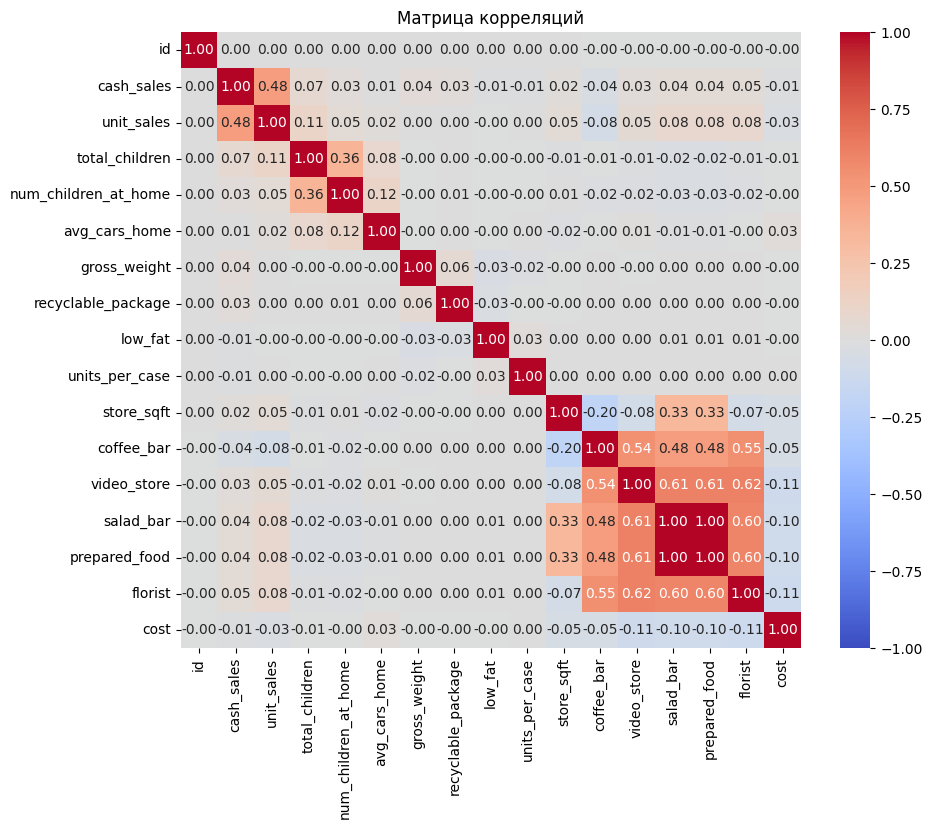

In [941]:
# Шаг 1: Вычисляем матрицу корреляций
corr_matrix = df.corr()

# Шаг 2: Строим тепловую карту (heatmap)
plt.figure(figsize=(10, 8))  # Размер графика
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Добавляем заголовок
plt.title('Матрица корреляций')

# Показываем график
plt.show()

Выводы по корреляции:
- Полная положительная корреляция salad_bar и prepared_food. Возможна мультиколлинеарность. Удалю salad_bar;
- coffee_bar, video_store, salad_bar, prepared_food, florist имеют умеренные кореляции между собой. можно уменьшить кол-во. Но оставлю как есть;
- gross_weight, recyclable_package корреляция близка к 0, думаю не несут смысловой нагрузки. Удаляю обе колонки.

In [942]:
# Удаление столбцов которые не влияют на cost
df = df.drop(columns=['id', 'gross_weight', 'num_children_at_home', 'recyclable_package', 'low_fat', 'units_per_case', 'salad_bar'])




In [943]:
df = df.drop(df[df['unit_sales'] == 0].index)

In [944]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Предположим, df — ваш DataFrame

# # Шаг 1: Выделяем нужные столбцы
# features = ['coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']
# X = df[features]

# # Шаг 2: Масштабируем данные (PCA требует стандартизации)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Шаг 3: Применяем PCA
# pca = PCA(n_components=2)  # Уменьшаем до 2 компонент
# X_pca = pca.fit_transform(X_scaled)

# # Шаг 4: Анализируем результаты
# print("Объяснённая дисперсия каждой компоненты:", pca.explained_variance_ratio_)
# print("Суммарная объяснённая дисперсия:", sum(pca.explained_variance_ratio_))

# # Шаг 5: Добавляем новые компоненты в DataFrame
# df['PCA_1'] = X_pca[:, 0]  # Первая компонента
# df['PCA_2'] = X_pca[:, 1]  # Вторая компонента

# # Вывод результата
# print(df[['PCA_1', 'PCA_2']].head())

In [945]:
# масштабирование данных применим МинМах (пробовал другие, особой разницы не увидел)

# Создаем объект MinMaxScaler
scaler = MinMaxScaler()

# Масштабируем данные
scaled_data = scaler.fit_transform(df)

# Преобразуем результат обратно в DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

df['store_sqft'] = df['store_sqft']/1000
# df['cost'] = df['cost']/10

In [946]:
eda_df = return_eda(df)
eda_df

,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,
cash_sales,0.0,22.920,0.510,6.337376,5.780,10.942729,2.320,11.040,3.720,8.400,356907,float64,1044,0,0,3442
unit_sales,0.0,6.000,1.000,3.043881,3.000,0.615716,2.000,4.000,3.000,4.000,0,int64,6,0,6765,31
total_children,0.0,5.000,0.000,2.456482,2.000,2.217097,0.000,4.000,1.000,4.000,0,int64,6,36441,0,0
avg_cars_home,0.0,4.000,0.000,2.203813,2.000,1.175692,1.000,4.000,1.000,3.000,0,int64,5,18537,0,0
store_sqft,0.0,39.696,20.319,28.180333,27.694,35.627458,21.215,38.382,23.593,33.858,360336,float64,20,0,0,0
coffee_bar,0.0,1.000,0.000,0.564839,1.000,0.245797,0.000,1.000,0.000,1.000,0,int64,2,156804,0,0
video_store,0.0,1.000,0.000,0.277394,0.000,0.200447,0.000,1.000,0.000,1.000,0,int64,2,260381,0,0
prepared_food,0.0,1.000,0.000,0.504832,1.000,0.249977,0.000,1.000,0.000,1.000,0,int64,2,178427,0,0
florist,0.0,1.000,0.000,0.503191,1.000,0.249991,0.000,1.000,0.000,1.000,0,int64,2,179018,0,0


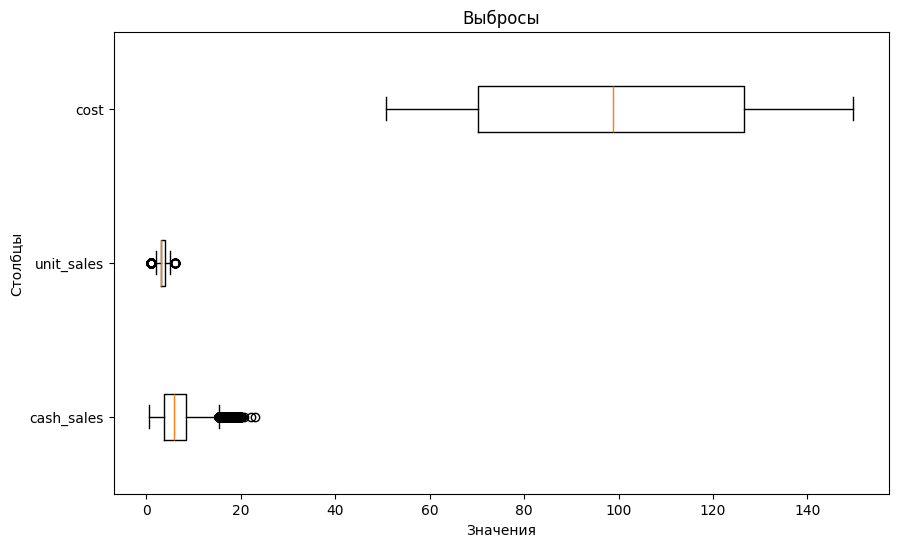

In [947]:
# Посмотрим на выбросы
df_filtered = df[['cash_sales', 'unit_sales', 'cost']] # Столбцы в ручную  переделать на eda_df
return_boxplot(df_filtered, 'Выбросы').show()

Выводы:
- cash_sales. Беда!!!  Пожертвую 0,95% данных.
- количество продаж в штуках имеет всего 6 значений, категориальный?. Нет времени Пожертвую еще частью данных (примерно-3% данных)

In [948]:
Q1 = df['cash_sales'].quantile(0.25)  # Первый квартиль (25-й процентиль)
Q3 = df['cash_sales'].quantile(0.75)  # Третий квартиль (75-й процентиль)
IQR = Q3 - Q1  # Межквартильный размах

# Шаг 2: Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Шаг 3: Удаляем выбросы
# Оставляем только те строки, где значения находятся в пределах [lower_bound, upper_bound]
df = df[(df['cash_sales'] >= lower_bound) & (df['cash_sales'] <= upper_bound)]

In [949]:
Q1 = df['unit_sales'].quantile(0.25)  # Первый квартиль (25-й процентиль)
Q3 = df['unit_sales'].quantile(0.75)  # Третий квартиль (75-й процентиль)
IQR = Q3 - Q1  # Межквартильный размах

# Шаг 2: Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Шаг 3: Удаляем выбросы
# Оставляем только те строки, где значения находятся в пределах [lower_bound, upper_bound]
df = df[(df['unit_sales'] >= lower_bound) & (df['unit_sales'] <= upper_bound)]

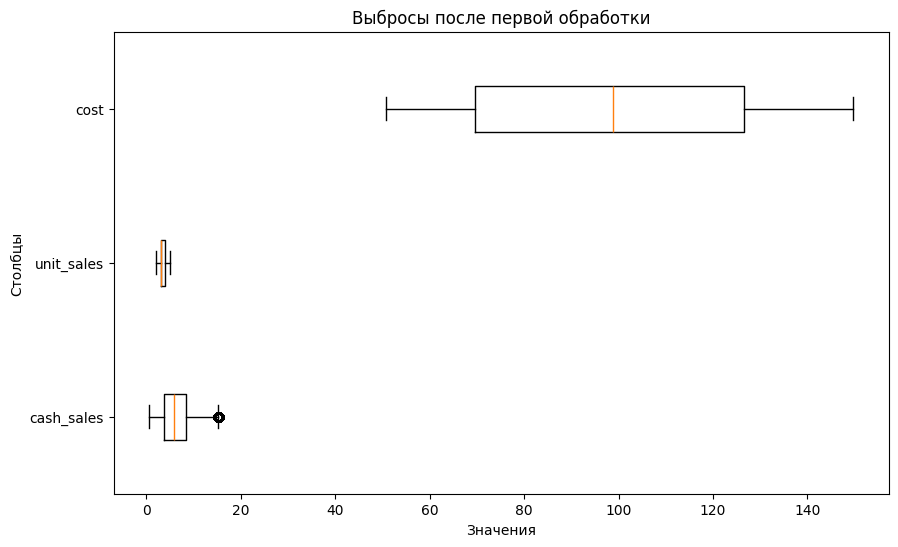

In [950]:
# Посмотрим на выбросы
df_filtered = df[['cash_sales', 'unit_sales', 'cost']]
return_boxplot(df_filtered, 'Выбросы после первой обработки').show()

Выбросы в cash_sales появилсиь новые, но сосредоточены у правого края. Заменю на верхний уровень

In [951]:
def get_iqr_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Вычисляем границы для каждого столбца
g_lower, g_upper = get_iqr_bounds(df['cash_sales'])

df['cash_sales'] = df['cash_sales'].clip(upper=g_upper)


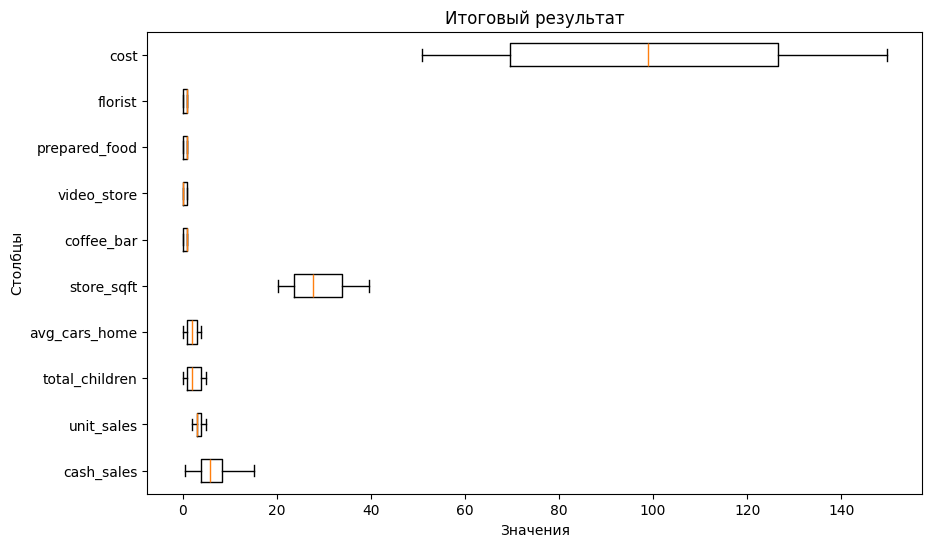

In [952]:
return_boxplot(df, 'Итоговый результат').show()

Ну так, что то похоже... Напишите, если не затруднит, в чем мои ошибки.

In [953]:
# Выделяем целевую переменную и признаки
X = df.drop(columns=['cost'])  # Признаки (все столбцы, кроме 'id' и 'cost')
X
# X = df['cash_sales', 'store_sqft']
y = df['cost']  # Целевая переменная

# Добавляем константу для statsmodels (для intercept)
X = sm.add_constant(X)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 2: Регрессия с помощью statsmodels (OLS)
model_sm = sm.OLS(y_train, X_train).fit()  # Обучаем модель
# print(model_sm.summary())  # Выводим статистику модели

# Шаг 3: Регрессия с помощью scikit-learn
model_sk = LinearRegression()
model_sk.fit(X_train.drop(columns=['const']), y_train)  # Обучаем модель (const не нужен для scikit-learn)

# Шаг 4: Предсказания
y_pred_sm = model_sm.predict(X_test)  # Предсказания для statsmodels
y_pred_sk = model_sk.predict(X_test.drop(columns=['const']))  # Предсказания для scikit-learn

# Шаг 5: Оценка качества модели
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE в процентах
    r2 = r2_score(y_true, y_pred)  # R² (коэффициент детерминации)

    print(f"Метрики для модели {model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R²: {r2:.4f}")
    print()

# Оценка для statsmodels
evaluate_model(y_test, y_pred_sm, "statsmodels OLS")

# Оценка для scikit-learn
evaluate_model(y_test, y_pred_sk, "scikit-learn LinearRegression")

Метрики для модели statsmodels OLS:
MAE: 25.6438
MSE: 882.4357
RMSE: 29.7058
MAPE: 29.7921%
R²: 0.0198

Метрики для модели scikit-learn LinearRegression:
MAE: 25.6438
MSE: 882.4357
RMSE: 29.7058
MAPE: 29.7921%
R²: 0.0198

